In [1]:
%%capture

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

from model import LSTMBaseModel, RNNBaseModel
from train import RNNTrainer

from sklearn.metrics import accuracy_score, classification_report

%run etl_feature.ipynb
%run etl_load.ipynb

### Index Normalizing

In [2]:
def upsample_to_hourly(df):
    if pd.infer_freq(df.index) == 'D':
        return df.resample('H').ffill() 
    return df

df_weather = upsample_to_hourly(df_weather)
df_cloud = upsample_to_hourly(df_cloud)

/var/folders/fx/vf6fk88550923hfq9c5dw5pm0000gn/T/ipykernel_22016/2070566789.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.resample('H').ffill()


In [3]:
def _split(df: pd.DataFrame, target_col: str):    
    df = df.sort_index()

    features = df.drop(columns=[target_col])
    target = df[[target_col]]  

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Create sequences
    def create_sequences(X, y, window_size):
        Xs, ys = [], []
        for i in range(len(X) - window_size):
            Xs.append(X[i:i+window_size])
            ys.append(y[i+window_size])
        return np.array(Xs), np.array(ys)

    window_size = 24  # Use 24 hours of data
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

    # Train/test split
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    return X_train, X_test, y_train, y_test, window_size, split, scaler_y
def _decompose(df: pd.DataFrame) -> pd.DataFrame:
    df["hour"] = df.index.hour
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["month"] = df.index.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df = df.drop(columns=["hour", "month"])

    return df


### Modeling ERCOT Solar Generation

<Axes: >

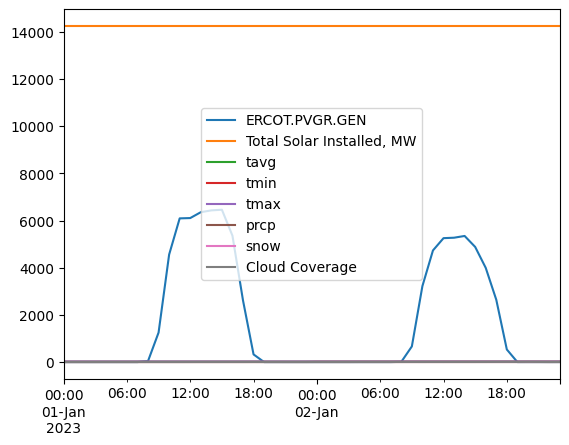

In [37]:
# Select features
df_solar_features = df_solar[["ERCOT.PVGR.GEN", "Total Solar Installed, MW"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "snow"]]
df_cloud_features = df_cloud[["Cloud Coverage"]]  # wrap in [[]] to keep DataFrame

# Remove duplicate indices
df_solar_features = df_solar_features[~df_solar_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]
df_cloud_features = df_cloud_features[~df_cloud_features.index.duplicated(keep='first')]

# Combine side-by-side on common datetime index
df = pd.concat([df_solar_features, df_weather_features, df_cloud_features], axis=1, join="inner")

# Fill or drop missing values
df = df.fillna(0)  # OR df = df.dropna()

df.to_csv("Solar.csv")

In [32]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y = _split(df = df, target_col="ERCOT.PVGR.GEN")

Epoch 1/100 | Train Loss: 0.7645 | Val Loss: 1.2184
Epoch 2/100 | Train Loss: 0.7293 | Val Loss: 1.2496
Epoch 3/100 | Train Loss: 0.6987 | Val Loss: 1.2497
Epoch 4/100 | Train Loss: 0.6897 | Val Loss: 1.1972
Epoch 5/100 | Train Loss: 0.6720 | Val Loss: 1.1844
Epoch 6/100 | Train Loss: 0.6665 | Val Loss: 1.2164
Epoch 7/100 | Train Loss: 0.6510 | Val Loss: 1.1903
Epoch 8/100 | Train Loss: 0.6351 | Val Loss: 1.3410
Epoch 9/100 | Train Loss: 0.6183 | Val Loss: 1.2731
Epoch 10/100 | Train Loss: 0.6031 | Val Loss: 1.1676
Epoch 11/100 | Train Loss: 0.5918 | Val Loss: 1.2936
Epoch 12/100 | Train Loss: 0.5768 | Val Loss: 1.2425
Epoch 13/100 | Train Loss: 0.5566 | Val Loss: 1.1986
Epoch 14/100 | Train Loss: 0.5443 | Val Loss: 1.1735
Epoch 15/100 | Train Loss: 0.5272 | Val Loss: 1.3163
Epoch 16/100 | Train Loss: 0.5219 | Val Loss: 1.2145
Epoch 17/100 | Train Loss: 0.4978 | Val Loss: 1.2237
Epoch 18/100 | Train Loss: 0.4914 | Val Loss: 1.2541
Epoch 19/100 | Train Loss: 0.4763 | Val Loss: 1.2774
Ep

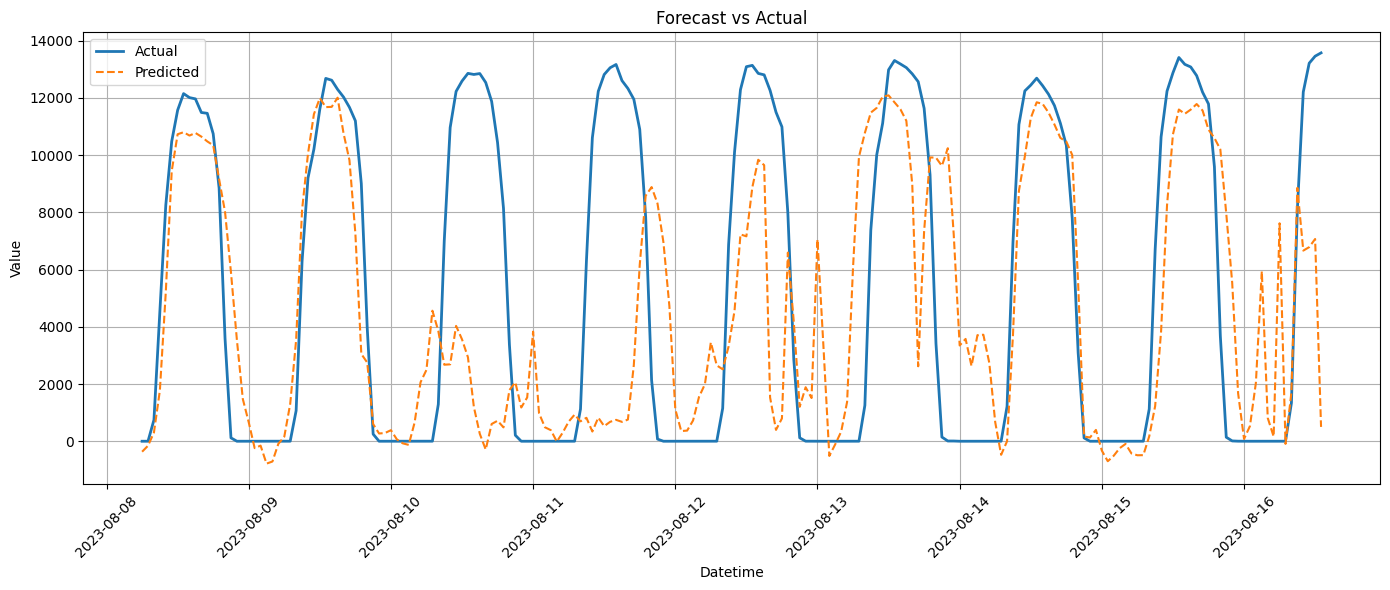

In [35]:
model1 = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64, dropout=0.4)
trainer = RNNTrainer(model1)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=100)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

Epoch 1/20 | Train Loss: 0.7455 | Val Loss: 1.1409
Epoch 2/20 | Train Loss: 0.6438 | Val Loss: 1.7116
Epoch 3/20 | Train Loss: 0.5660 | Val Loss: 1.1219
Epoch 4/20 | Train Loss: 0.4853 | Val Loss: 1.0776
Epoch 5/20 | Train Loss: 0.4043 | Val Loss: 1.1487
Epoch 6/20 | Train Loss: 0.3649 | Val Loss: 0.9386
Epoch 7/20 | Train Loss: 0.3376 | Val Loss: 1.3935
Epoch 8/20 | Train Loss: 0.2917 | Val Loss: 1.4461
Epoch 9/20 | Train Loss: 0.2732 | Val Loss: 1.5117
Epoch 10/20 | Train Loss: 0.2694 | Val Loss: 1.1561
Epoch 11/20 | Train Loss: 0.2396 | Val Loss: 1.3575
Epoch 12/20 | Train Loss: 0.2316 | Val Loss: 1.1153
Epoch 13/20 | Train Loss: 0.2136 | Val Loss: 1.4157
Epoch 14/20 | Train Loss: 0.2074 | Val Loss: 1.1777
Epoch 15/20 | Train Loss: 0.1993 | Val Loss: 1.2538
Epoch 16/20 | Train Loss: 0.1902 | Val Loss: 1.3056
Epoch 17/20 | Train Loss: 0.1776 | Val Loss: 1.1478
Epoch 18/20 | Train Loss: 0.1731 | Val Loss: 1.2994
Epoch 19/20 | Train Loss: 0.1704 | Val Loss: 1.1860
Epoch 20/20 | Train L

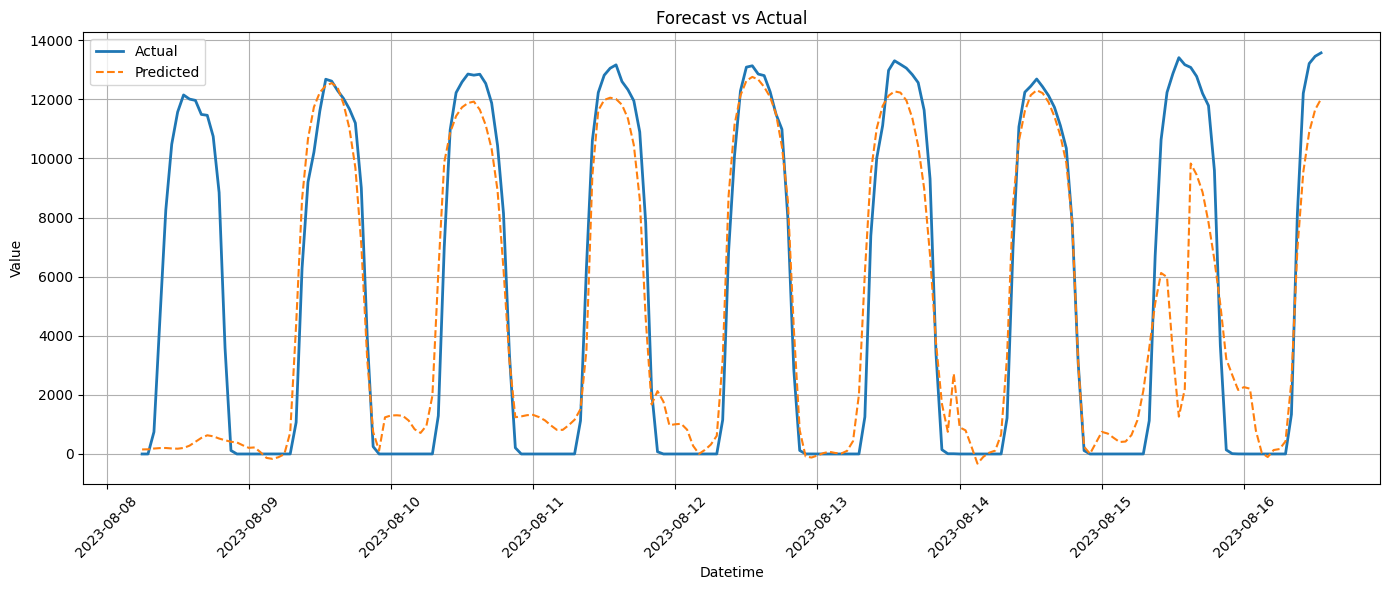

In [36]:
df = _decompose(df)

model2 = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model2)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import torch
import numpy as np

model1.eval()
model2.eval()

with torch.no_grad():
    if isinstance(X_test, np.ndarray):
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    else:
        X_test_tensor = X_test
        y_test_tensor = y_test

    y_pred1 = model1(X_test_tensor).cpu().numpy().flatten()
    y_pred2 = model2(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()

# Compute metrics
mse1 = mean_squared_error(y_true, y_pred1)
mse2 = mean_squared_error(y_true, y_pred2)

r2_1 = r2_score(y_true, y_pred1)
r2_2 = r2_score(y_true, y_pred2)

r_1, _ = pearsonr(y_true, y_pred1)
r_2, _ = pearsonr(y_true, y_pred2)

# Display results
print("Model 1 (RNN):")
print(f"  MSE  = {mse1:.4f}")
print(f"  R²   = {r2_1:.4f}")
print(f"  R    = {r_1:.4f}")

print("\nModel 2 (LSTM):")
print(f"  MSE  = {mse2:.4f}")
print(f"  R²   = {r2_2:.4f}")
print(f"  R    = {r_2:.4f}")

# Compare
if mse1 < mse2:
    print("\n✅ Model 1 (RNN) is more accurate based on MSE.")
else:
    print("\n✅ Model 2 (LSTM) is more accurate based on MSE.")


Model 1 (RNN):
  MSE  = 1.4346
  R²   = -0.0130
  R    = 0.4387

Model 2 (LSTM):
  MSE  = 1.0448
  R²   = 0.2622
  R    = 0.6386

✅ Model 2 (LSTM) is more accurate based on MSE.


### Modeling Wind Generation

In [38]:
df_wind_features = df_wind[["ERCOT.WIND.GEN", "Total Wind Installed, MW"]]
df_wind_weather_features = df_weather[["snow", "wdir", "wspd"]]

# Drop duplicates from each DataFrame (based on datetime index)
df_wind_features = df_wind_features[~df_wind_features.index.duplicated(keep='first')]
df_wind_weather_features = df_wind_weather_features[~df_wind_weather_features.index.duplicated(keep='first')]

# Proper merge — side-by-side on matching datetime index
df = pd.concat([df_wind_features, df_wind_weather_features], axis=1, join="inner")

# Clean NA
df = df.fillna(0)
df = df.dropna()



df.to_csv("Wind.csv")

In [ ]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y = _split(df = df, target_col="ERCOT.WIND.GEN")

Epoch 1/20 | Train Loss: 1.1583 | Val Loss: 1.1221
Epoch 2/20 | Train Loss: 0.8929 | Val Loss: 1.0338
Epoch 3/20 | Train Loss: 0.8577 | Val Loss: 1.0904
Epoch 4/20 | Train Loss: 0.8264 | Val Loss: 1.1294
Early stopping triggered


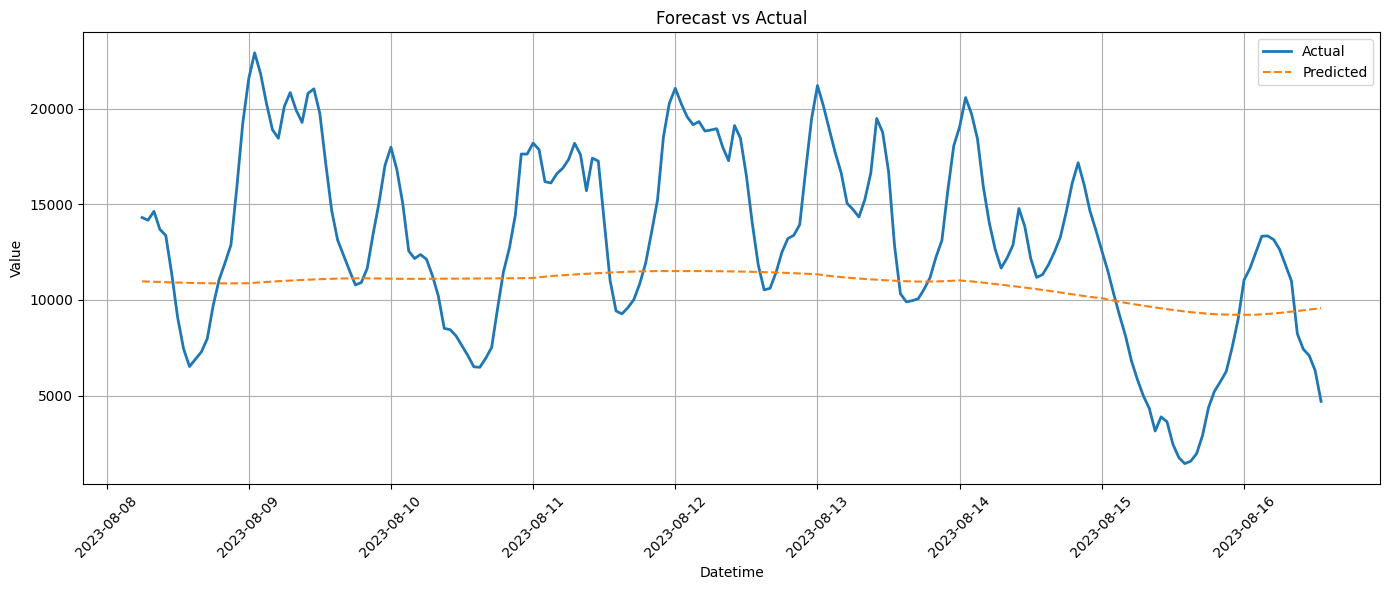

In [ ]:
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)


Epoch 1/30 | Train Loss: 1.1964 | Val Loss: 1.2002
Epoch 2/30 | Train Loss: 0.8886 | Val Loss: 1.0244
Epoch 3/30 | Train Loss: 0.8633 | Val Loss: 1.1571
Epoch 4/30 | Train Loss: 0.8223 | Val Loss: 1.2204
Early stopping triggered


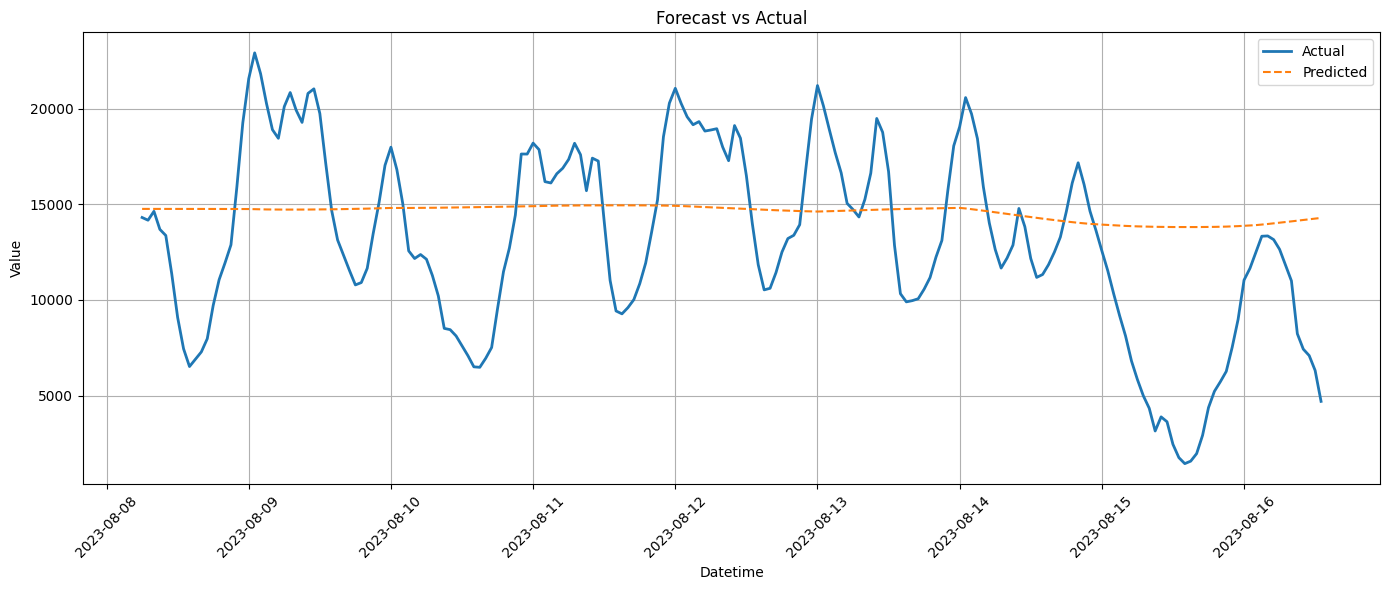

In [ ]:
df = _decompose(df)

model = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=30)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

### Load forecasting

In [39]:
df_load_features = df_load[["ERCOT"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "wdir", "wspd"]]

# Drop duplicates
df_load_features = df_load_features[~df_load_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]

# Sort index to avoid alignment issues
df_load_features = df_load_features.sort_index()
df_weather_features = df_weather_features.sort_index()

# Merge side-by-side on datetime index
df = pd.concat([df_load_features, df_weather_features], axis=1, join="inner")

# Fill and drop missing values
df = df.fillna(0)
df = df.dropna()

df.to_csv("Load.csv")

In [ ]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y  = _split(df = df, target_col="ERCOT")

Epoch 1/20 | Train Loss: 0.6502 | Val Loss: 0.4999
Epoch 2/20 | Train Loss: 0.4418 | Val Loss: 0.4643
Epoch 3/20 | Train Loss: 0.4243 | Val Loss: 0.5103
Epoch 4/20 | Train Loss: 0.4151 | Val Loss: 0.4893
Early stopping triggered


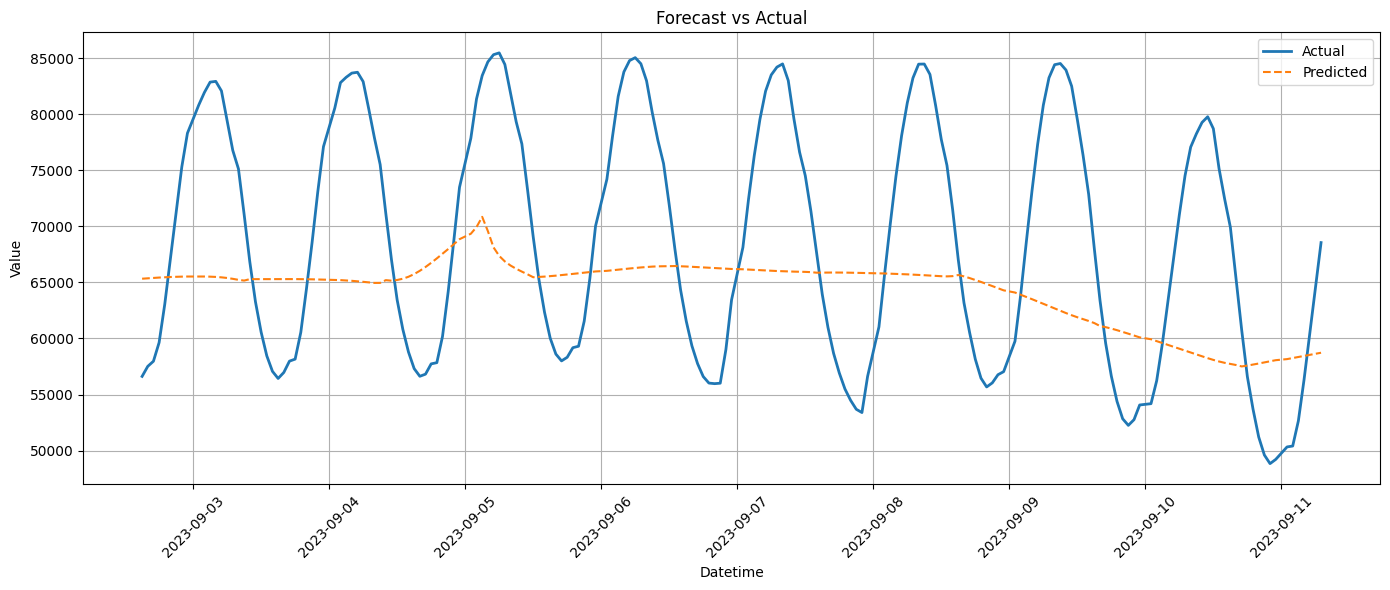

In [ ]:
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)


In [ ]:
df = _decompose(df)

model = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=30)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

Epoch 1/30 | Train Loss: 0.6259 | Val Loss: 0.4802
Epoch 2/30 | Train Loss: 0.4332 | Val Loss: 0.4580
